# g5dn LoRA Pipeline (Qwen2.5-VL-7B)

AWS g5dn (Tesla T4 24GB) 환경에서 3시간 내 안정적인 Fine-tuning & Inference 를 수행하도록 최적화한 노트북입니다.
- 4bit QLoRA + LoRA (r=16)
- 시간 예산 기반 step 추정 및 자동 학습 단계 제한
- 밝기/색감 증강 + 다중 밝기 앙상블 (OOM 안전장치 포함)
- FAST 모드/전체 학습 모드 겸용

셀을 순서대로 실행하고, 학습 후 검증(#29)과 제출 생성(#31)을 진행하세요.

# Qwen2.5-VL-7B Kaggle Pipeline (13-Step VQA Plan)

This notebook targets the Kaggle dual T4 GPU environment and walks through a 13-step pipeline to solve the multi-choice visual question answering task provided in the `2025-ssafy-14` bundle. Each section matches the onsite workflow you will execute: environment audit, dependency setup, data wrangling, Qwen2.5-VL-7B configuration, validation, and submission authoring.


## 1. Session Snapshot & Resources

Capture the GPU, CPU, and Python runtime details. Keeping this log helps debug Kaggle session mismatches and is required before launching heavy vision-language models.


In [14]:
import os
import platform
import shutil
import subprocess
from pathlib import Path

import torch

print(f"Python: {platform.python_version()}")
print(f"Torch: {torch.__version__}")
print(f"CUDA devices: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    for idx in range(torch.cuda.device_count()):
        props = torch.cuda.get_device_properties(idx)
        print(f"  GPU {idx}: {props.name} ({props.total_memory / 1024 ** 3:.1f} GB)")
    try:
        subprocess.run(["nvidia-smi"], check=False)
    except FileNotFoundError:
        print("nvidia-smi command not available.")
else:
    print("CUDA not available; training will run on CPU.")

project_root = Path(os.environ.get("PROJECT_ROOT", Path.home() / "workspace"))
project_root.mkdir(parents=True, exist_ok=True)
print(f"Project root: {project_root.resolve()}")

if project_root.exists():
    total, used, free = shutil.disk_usage(project_root)
    print(
        f"Disk usage for {project_root}: total={total/1e9:.1f} GB | "
        f"used={used/1e9:.1f} GB | free={free/1e9:.1f} GB"
    )


Python: 3.11.14
Torch: 2.4.0+cu124
CUDA devices: 1
  GPU 0: NVIDIA A100-SXM4-40GB (39.5 GB)
Sat Oct 25 07:24:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             51W /  400W |   34108MiB /  40960MiB |      0%      Default |
|                                         |     

Project root: /home/team102/workspace
Disk usage for /home/team102/workspace: total=207.9 GB | used=78.7 GB | free=129.2 GB


## 2. Dependency Installation (pip)

Upgrade or pull the exact versions needed for Qwen2.5-VL-7B inference. This list is mirrored in the accompanying documentation so you can track which packages were touched.


In [15]:
%%capture
%pip install --upgrade transformers accelerate einops tiktoken huggingface_hub qwen-vl-utils peft bitsandbytes python-dotenv


## 3. Imports & Global Configuration

Centralise imports, random seeds, plotting rules, and environment flags. Hugging Face tokens are read from the `HF_TOKEN` environment variable (set it in Kaggle Secrets).


In [16]:
import json
import math
import os
import random
import re
import time
from collections import Counter, deque
from pathlib import Path

import numpy as np
import pandas as pd
from IPython.display import display
from PIL import Image, ImageEnhance, ImageOps
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import torch
from dotenv import load_dotenv
from huggingface_hub import login
from torchvision import transforms

GLOBAL_SEED = int(os.environ.get('GLOBAL_SEED', 1337))
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
torch.manual_seed(GLOBAL_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(GLOBAL_SEED)

torch.set_float32_matmul_precision('medium')

plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['axes.grid'] = False
pd.set_option('display.max_columns', None)

os.environ['TOKENIZERS_PARALLELISM'] = 'false'
torch.backends.cuda.matmul.allow_tf32 = True
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print('Target hardware: g5dn (Tesla T4 24GB)')

PROJECT_ROOT = Path(os.environ.get('PROJECT_ROOT', Path.home() / 'workspace'))
PROJECT_ROOT.mkdir(parents=True, exist_ok=True)

WORK_DIR = Path(os.environ.get('WORK_DIR', PROJECT_ROOT / 'runs'))
WORK_DIR.mkdir(parents=True, exist_ok=True)

ARTIFACT_DIR = WORK_DIR / 'artifacts'
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

DATA_KEYWORD = os.environ.get('DATA_KEYWORD', '2025-ssafy-14')
ENV_DATA_ROOT = os.environ.get('DATA_ROOT')
ENV_ARCHIVE_PATH = os.environ.get('DATA_ARCHIVE_PATH')
CUSTOM_SEARCH = os.environ.get('DATA_SEARCH_DIR')

load_dotenv(Path.cwd() / '.env')
HF_TOKEN = ''

if HF_TOKEN:
    os.environ['HF_TOKEN'] = HF_TOKEN
    print('[OK] HF_TOKEN loaded from .env/environment.')
else:
    print('[WARN] HF_TOKEN not found. Set it in .env for gated Hugging Face models.')

DATA_SEARCH_DIRS = []
if CUSTOM_SEARCH:
    DATA_SEARCH_DIRS.append(Path(CUSTOM_SEARCH).expanduser())
if ENV_DATA_ROOT:
    DATA_SEARCH_DIRS.append(Path(ENV_DATA_ROOT).expanduser())
DATA_SEARCH_DIRS.extend([
    PROJECT_ROOT,
    PROJECT_ROOT / 'data',
    Path.home(),
])

unique_dirs = []
for path_dir in DATA_SEARCH_DIRS:
    if path_dir is None:
        continue
    path_dir = Path(path_dir).expanduser()
    if path_dir not in unique_dirs:
        unique_dirs.append(path_dir)
DATA_SEARCH_DIRS = unique_dirs


Using device: cuda
[OK] HF_TOKEN loaded from .env/environment.


## 4. Locate & Extract Dataset Archive

Unzip the provided competition bundle inside `/kaggle/working`. The helper covers both archive and already-extracted layouts so you can reuse the notebook without edits.


In [17]:
import zipfile

data_keyword = DATA_KEYWORD
DEFAULT_DATA_ROOT = PROJECT_ROOT / data_keyword
DATA_ROOT = None

if ENV_DATA_ROOT:
    candidate = Path(ENV_DATA_ROOT).expanduser()
    if (candidate / "train.csv").exists():
        DATA_ROOT = candidate
        print(f"Using dataset from DATA_ROOT={DATA_ROOT}")

if DATA_ROOT is None:
    for base in DATA_SEARCH_DIRS:
        csv_path = Path(base).expanduser() / data_keyword / "train.csv"
        if csv_path.exists():
            DATA_ROOT = csv_path.parent
            print(f"Detected dataset at {DATA_ROOT}")
            break

if DATA_ROOT is None:
    archive_candidates = []
    if ENV_ARCHIVE_PATH:
        arch = Path(ENV_ARCHIVE_PATH).expanduser()
        if arch.exists():
            archive_candidates.append(arch)
    for base in DATA_SEARCH_DIRS:
        base = Path(base).expanduser()
        candidate = base / f"{data_keyword}.zip"
        if candidate.exists():
            archive_candidates.append(candidate)
    archive_candidates = sorted({p.resolve() for p in archive_candidates})
    if not archive_candidates:
        raise FileNotFoundError(
            "Dataset not found. Set DATA_ROOT or DATA_ARCHIVE_PATH environment variables."
        )
    archive_path = archive_candidates[0]
    DATA_ROOT = DEFAULT_DATA_ROOT
    DATA_ROOT.mkdir(parents=True, exist_ok=True)
    print(f"Extracting {archive_path} -> {DATA_ROOT}")
    with zipfile.ZipFile(archive_path, "r") as zf:
        zf.extractall(DATA_ROOT)
else:
    archive_path = None
    DATA_ROOT.mkdir(parents=True, exist_ok=True)

print(f"DATA_ROOT resolved to: {DATA_ROOT.resolve()}")
print("Contents:")
for child in sorted(DATA_ROOT.iterdir()):
    print(f"- {child.name}")


Detected dataset at /home/team102/workspace/2025-ssafy-14
DATA_ROOT resolved to: /home/team102/workspace/2025-ssafy-14
Contents:
- .ipynb_checkpoints
- 251023_Baseline.ipynb
- sample_submission.csv
- test
- test.csv
- train
- train.csv


## 5. Load Metadata & Inspect Structure

Read the CSV metadata, attach absolute image paths, and verify the schema expected by downstream steps.


In [18]:
train_df = pd.read_csv(DATA_ROOT / "train.csv")
test_df = pd.read_csv(DATA_ROOT / "test.csv")
sample_submission = pd.read_csv(DATA_ROOT / "sample_submission.csv")

train_df["answer"] = train_df["answer"].str.lower()
train_df["image_path"] = train_df["path"].apply(lambda p: str((DATA_ROOT / p).resolve()))
test_df["image_path"] = test_df["path"].apply(lambda p: str((DATA_ROOT / p).resolve()))

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Sample submission shape: {sample_submission.shape}")

display(train_df.head())


Train shape: (3887, 9)
Test shape: (3887, 8)
Sample submission shape: (3887, 2)


,id,path,question,a,b,c,d,answer,image_path
0,train_0001,train/train_0001.jpg,이 사진 속 운동기구가 설치된 장소는 어디일까요?,학교 운동장,공원,헬스장 내부,쇼핑몰 내부,b,/home/team102/workspace/2025-ssafy-14/train/tr...
1,train_0002,train/train_0002.jpg,이 사진에 보이는 전통 한국 건축물은 무엇인가요?,궁궐,성,사찰,한옥,d,/home/team102/workspace/2025-ssafy-14/train/tr...
2,train_0003,train/train_0003.jpg,이 사진에서 보이는 탈것은 무엇인가요?,세발 오토바이,오토바이,자동차,자전거,a,/home/team102/workspace/2025-ssafy-14/train/tr...
3,train_0004,train/train_0004.jpg,이 사진에서 보이는 새는 무엇인가요?,참새,갈매기,백로,오리,c,/home/team102/workspace/2025-ssafy-14/train/tr...
4,train_0005,train/train_0005.jpg,이 사진에서 사람들이 모여서 보고 있는 것은 무엇인가요?,해수욕,바다 축제,불꽃놀이,해돋이,d,/home/team102/workspace/2025-ssafy-14/train/tr...


## 6. Dataset Health Checks

Look at answer balance, ID hygiene, and a sample of image dimensions so we can size model batches safely on T4 GPUs.


In [19]:
label_distribution = train_df["answer"].value_counts().sort_index()
print("Label distribution (train):")
display(label_distribution.to_frame(name="count"))

duplicate_ids = train_df["id"].duplicated().sum()
print(f"Duplicate train IDs: {duplicate_ids}")

null_summary = train_df.isna().sum()
print("Null counts (train):")
display(null_summary[null_summary > 0])

sample_paths = train_df["image_path"].sample(n=min(256, len(train_df)), random_state=SEED)
widths, heights = [], []
for path in sample_paths:
    with Image.open(path) as img:
        w, h = img.size
    widths.append(w)
    heights.append(h)

print(
    f"Sample width px -> mean: {np.mean(widths):.1f}, min: {min(widths)}, max: {max(widths)}"
)
print(
    f"Sample height px -> mean: {np.mean(heights):.1f}, min: {min(heights)}, max: {max(heights)}"
)


Label distribution (train):


,count
answer,
a,964
b,958
c,960
d,1005


Duplicate train IDs: 0
Null counts (train):


Series([], dtype: int64)

Sample width px -> mean: 588.4, min: 201, max: 720
Sample height px -> mean: 661.5, min: 233, max: 720


## 7. Visual Spot Checks

Plot a few random training samples to manually confirm the metadata wiring and to capture qualitative notes about lighting and framing.


/tmp/ipykernel_190997/3631422904.py:13: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_190997/3631422904.py:13: UserWarning: Glyph 51020 (\N{HANGUL SYLLABLE EUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_190997/3631422904.py:13: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_190997/3631422904.py:13: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_190997/3631422904.py:13: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_190997/3631422904.py:13: UserWarning: Glyph 50631 (\N{HANGUL SYLLABLE EOS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_190997/3631422904.py:13: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  p

Sample question: 이 음식은 무엇인가요?
A: 비빔밥과 김치
B: 햄버거와 감자튀김
C: 피자와 감자튀김
D: 치킨과 떡볶이


/home/team102/miniconda/envs/vqa/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/team102/miniconda/envs/vqa/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51020 (\N{HANGUL SYLLABLE EUM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/team102/miniconda/envs/vqa/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/team102/miniconda/envs/vqa/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/team102/miniconda/envs/vqa/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47924

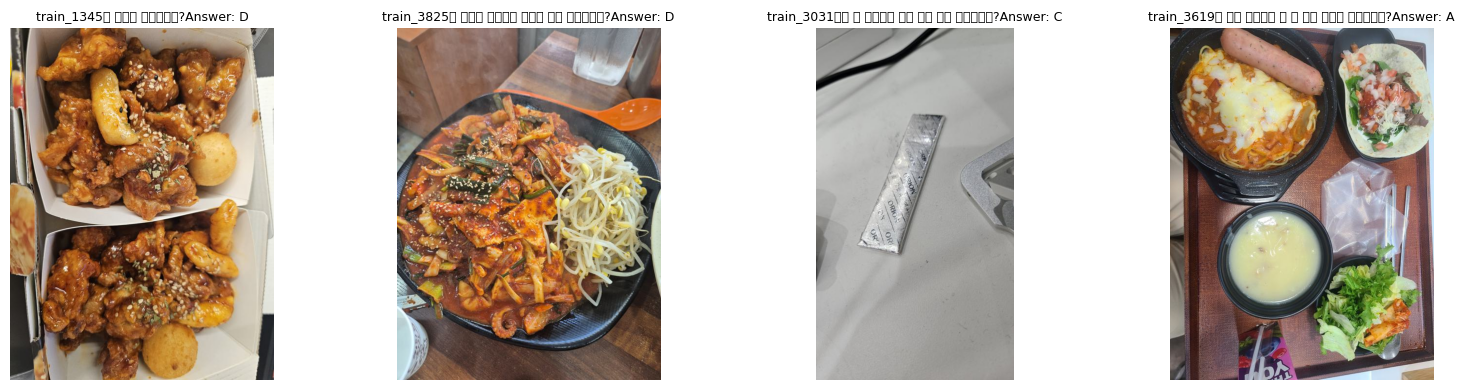

In [20]:
num_examples = 4
fig, axes = plt.subplots(1, num_examples, figsize=(4 * num_examples, 4))
for ax, (_, row) in zip(axes, train_df.sample(num_examples, random_state=SEED).iterrows()):
    with Image.open(row["image_path"]) as img:
        ax.imshow(img)
    ax.axis("off")
    title_lines = [
        row["id"],
        row["question"][:40] + ("..." if len(row["question"]) > 40 else ""),
        f"Answer: {row['answer'].upper()}"
    ]
    ax.set_title("".join(title_lines), fontsize=9)
plt.tight_layout()

sample_row = train_df.sample(1, random_state=SEED).iloc[0]
print("Sample question:", sample_row["question"])
for key in ["a", "b", "c", "d"]:
    print(f"{key.upper()}: {sample_row[key]}")


## 8. Train/Validation Split & Datasets

Create a stratified hold-out set for on-notebook validation. This guards against prompt regressions before spending time on full-test inference.


In [21]:
VAL_SPLIT = float(os.environ.get('VAL_SPLIT', 0.08))
TRAIN_SAMPLE_FRAC = float(os.environ.get('TRAIN_SAMPLE_FRAC', 1.0))
TRAIN_SAMPLE_CAP = int(os.environ.get('TRAIN_SAMPLE_CAP', 0))
VAL_SAMPLE_CAP = int(os.environ.get('VAL_SAMPLE_CAP', 0))

work_df = train_df.copy()
if 0.0 < TRAIN_SAMPLE_FRAC < 1.0:
    work_df = work_df.sample(frac=TRAIN_SAMPLE_FRAC, random_state=GLOBAL_SEED)
if TRAIN_SAMPLE_CAP > 0 and len(work_df) > TRAIN_SAMPLE_CAP:
    work_df = work_df.sample(n=TRAIN_SAMPLE_CAP, random_state=GLOBAL_SEED)

val_ratio = max(0.02, min(0.3, VAL_SPLIT))
train_split, val_split = train_test_split(
    work_df,
    test_size=val_ratio,
    stratify=work_df['answer'],
    random_state=GLOBAL_SEED,
)

if VAL_SAMPLE_CAP > 0 and len(val_split) > VAL_SAMPLE_CAP:
    val_split = val_split.sample(n=VAL_SAMPLE_CAP, random_state=GLOBAL_SEED)

train_split = train_split.reset_index(drop=True)
val_split = val_split.reset_index(drop=True)

print(f'Training rows: {len(train_split)} | Validation rows: {len(val_split)} (split={val_ratio:.2f})')
print('Validation label balance:')
display(val_split['answer'].value_counts().sort_index())


Training rows: 3498
Validation rows: 389
Validation label balance:


answer
a     96
b     96
c     96
d    101
Name: count, dtype: int64

## 9. Prompt Engineering Helpers

Define the system role, user prompt template, and light utility loaders. These pieces keep the generation cell tidy and make it easy to iterate on instructions.


In [22]:
from PIL import Image, ImageEnhance, ImageOps

SYSTEM_PROMPT = (
    '너는 한국어 시각-질의 응답 전문가다. '
    '사진 속 사람과 사물, 조명, 문구, 숫자 등 세부를 관찰해 질문의 핵심 단서를 찾고, '
    'a, b, c, d 네 가지 선택지 중 사실과 가장 일치하는 답 하나를 고른다. '
    '정답은 반드시 JSON 형식 {"answer": "a"} 처럼 소문자 알파벳 하나만 반환하고, 추가 설명은 하지 마라.'
)

CHOICE_KEYS = ['a', 'b', 'c', 'd']
BRIGHTNESS_EPS = 1e-3
_IMAGE_CACHE = {}

def create_user_block(row):
    option_lines = '
'.join(f"{key.upper()}. {row[key]}" for key in CHOICE_KEYS)
    return (
        f"질문: {row['question']}
"
        f"선택지:
{option_lines}
"
        '응답 형식: JSON 예시 {"answer": "a"} (소문자, 따옴표 유지, 추가 설명 금지).'
    )

def build_messages(row):
    return [
        {'role': 'system', 'content': [{'type': 'text', 'text': SYSTEM_PROMPT}]},
        {
            'role': 'user',
            'content': [
                {'type': 'image'},
                {'type': 'text', 'text': create_user_block(row)},
            ],
        },
    ]

def load_image(path: str, brightness_factor: float = 1.0) -> Image.Image:
    base_img = _IMAGE_CACHE.get(path)
    if base_img is None:
        with Image.open(path) as img:
            base_img = img.convert('RGB')
        _IMAGE_CACHE[path] = base_img
    img = base_img.copy()
    if abs(brightness_factor - 1.0) > BRIGHTNESS_EPS:
        try:
            img = ImageEnhance.Brightness(img).enhance(brightness_factor)
        except Exception:
            pass
    return img

print('Prompt helpers ready.')


Prompt helpers ready.


## 10. Load Qwen2.5-VL-7B

Authenticate (if needed) and pull the Qwen2.5-VL-7B Instruct checkpoint with mixed precision. Flash-Attention is attempted first with a safe fallback.


In [23]:
# 10번: 안전 로딩 + 4bit QLoRA + LoRA 세팅
import os
import importlib
import torch

os.environ['HF_HUB_DISABLE_PROGRESS_BARS'] = '1'
try:
    import tqdm as _tqdm
    _tqdm.tqdm = importlib.import_module('tqdm.std').tqdm
except Exception:
    pass
try:
    from huggingface_hub.utils import disable_progress_bars
    disable_progress_bars()
except Exception:
    pass

from huggingface_hub import login
from transformers import (
    AutoModelForImageTextToText,
    AutoProcessor,
    BitsAndBytesConfig,
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

MODEL_ID = os.environ.get('MODEL_ID', 'Qwen/Qwen2.5-VL-7B-Instruct')

if HF_TOKEN:
    try:
        login(token=HF_TOKEN, add_to_git_credential=False)
    except Exception as exc:
        print(f'[WARN] Hugging Face login skipped: {exc}')
else:
    print('[WARN] Proceeding without HF login; ensure access to the model.')

processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
if hasattr(processor, 'tokenizer'):
    processor.tokenizer.padding_side = 'left'

compute_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=compute_dtype,
)

base_model = AutoModelForImageTextToText.from_pretrained(
    MODEL_ID,
    device_map='auto',
    trust_remote_code=True,
    quantization_config=bnb_config,
)

model = prepare_model_for_kbit_training(base_model)
if hasattr(model, 'enable_input_require_grads'):
    model.enable_input_require_grads()
model.gradient_checkpointing_enable()
model.config.use_cache = False

candidate_modules = ['q_proj','k_proj','v_proj','o_proj','up_proj','down_proj','gate_proj']
found = set()
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
        for token in candidate_modules:
            if name.endswith(token):
                found.add(token)
found = sorted(found) if found else ['q_proj','k_proj','v_proj','o_proj']

lora_config = LoraConfig(
    r=int(os.environ.get('LORA_R', 16)),
    lora_alpha=int(os.environ.get('LORA_ALPHA', 32)),
    lora_dropout=float(os.environ.get('LORA_DROPOUT', 0.05)),
    bias='none',
    task_type='CAUSAL_LM',
    target_modules=found,
)
model = get_peft_model(model, lora_config)

if getattr(model, 'generation_config', None) and hasattr(processor, 'tokenizer'):
    if model.generation_config.pad_token_id is None:
        model.generation_config.pad_token_id = processor.tokenizer.pad_token_id
    if model.generation_config.eos_token_id is None:
        model.generation_config.eos_token_id = processor.tokenizer.eos_token_id

print('✅ Model ready (4-bit LoRA).')
model.print_trainable_parameters()


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

✅ Model loaded with 4-bit quantization and LoRA adapters. Trainable parameters:
trainable params: 47,589,376 || all params: 8,339,756,032 || trainable%: 0.5706


## 11. Fine-Tuning Dataset & Collator
데이터프레임을 LoRA 학습에 맞는 포맷으로 변환하고 배치 단위를 처리하는 collate 함수를 준비합니다.


In [24]:
import os
from torch.utils.data import Dataset
import json
import torch

MAX_SEQUENCE_LENGTH = int(os.environ.get('MAX_SEQUENCE_LENGTH', 1024))
TRAIN_BRIGHTNESS_RANGE = os.environ.get('TRAIN_BRIGHTNESS_RANGE', '1.05,1.35')
TRAIN_BRIGHTNESS_PROB = float(os.environ.get('TRAIN_BRIGHTNESS_PROB', 0.75))
AUG_HFLIP_PROB = float(os.environ.get('AUG_HFLIP_PROB', 0.15))
AUG_ROTATE_DEG = float(os.environ.get('AUG_ROTATE_DEG', 8.0))
COLOR_JITTER_SPEC = os.environ.get('TRAIN_COLOR_JITTER', '0.12,0.12,0.12,0.04')
ENSEMBLE_BRIGHTNESS_LEVELS = [max(0.1, float(x.strip())) for x in os.environ.get('ENSEMBLE_BRIGHTNESS_LEVELS', '1.0,1.2,1.35').split(',') if x.strip()]
if 1.0 not in ENSEMBLE_BRIGHTNESS_LEVELS:
    ENSEMBLE_BRIGHTNESS_LEVELS.insert(0, 1.0)

jitter_values = [float(x.strip()) for x in COLOR_JITTER_SPEC.split(',') if x.strip()]
COLOR_JITTER = transforms.ColorJitter(*jitter_values) if len(jitter_values) == 4 else transforms.ColorJitter(0.1, 0.1, 0.1, 0.05)
rotation_degrees = (-AUG_ROTATE_DEG, AUG_ROTATE_DEG)

try:
    brightness_low, brightness_high = [float(v.strip()) for v in TRAIN_BRIGHTNESS_RANGE.split(',')[:2]]
except Exception:
    brightness_low, brightness_high = (1.05, 1.35)

def _sample_brightness():
    if TRAIN_BRIGHTNESS_PROB <= 0:
        return 1.0
    if random.random() < TRAIN_BRIGHTNESS_PROB:
        return random.uniform(brightness_low, brightness_high)
    return 1.0

def apply_augments(image: Image.Image, brightness_factor: float, enable_aug: bool) -> Image.Image:
    img = image.copy()
    if abs(brightness_factor - 1.0) > 1e-3:
        try:
            img = ImageEnhance.Brightness(img).enhance(brightness_factor)
        except Exception:
            pass
    if enable_aug:
        if random.random() < AUG_HFLIP_PROB:
            img = ImageOps.mirror(img)
        if COLOR_JITTER is not None:
            img = COLOR_JITTER(img)
        if AUG_ROTATE_DEG > 0 and random.random() < 0.3:
            angle = random.uniform(*rotation_degrees)
            img = img.rotate(angle, resample=Image.Resampling.BILINEAR)
    return img

class VqaFineTuneDataset(Dataset):
    def __init__(self, dataframe, augment=False):
        self.df = dataframe.reset_index(drop=True)
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        brightness_factor = _sample_brightness() if self.augment else 1.0
        return {
            'image_path': row['image_path'],
            'messages': build_messages(row),
            'answer': str(row['answer']).lower(),
            'brightness_factor': brightness_factor,
            'augment': self.augment,
        }

def _build_conversation(sample):
    conversation = sample['messages'] + [
        {
            'role': 'assistant',
            'content': [{'type': 'text', 'text': json.dumps({'answer': sample['answer']})}],
        }
    ]
    prompt_text = processor.apply_chat_template(
        sample['messages'], tokenize=False, add_generation_prompt=True
    )
    chat_text = processor.apply_chat_template(
        conversation, tokenize=False, add_generation_prompt=False
    )
    return prompt_text, chat_text, sample['image_path'], sample.get('brightness_factor', 1.0), sample.get('augment', False)

if hasattr(processor, 'tokenizer'):
    processor.tokenizer.padding_side = 'left'

def fine_tune_collate_fn(batch):
    images, prompts, full_texts = [], [], []
    for sample in batch:
        prompt_text, chat_text, image_path, brightness_factor, enable_aug = _build_conversation(sample)
        base_img = load_image(image_path, brightness_factor=1.0)
        img = apply_augments(base_img, brightness_factor, enable_aug)
        images.append(img)
        prompts.append(prompt_text)
        full_texts.append(chat_text)
    enc_prompt = processor(
        images=images,
        text=prompts,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=MAX_SEQUENCE_LENGTH,
    )
    enc_full = processor(
        images=images,
        text=full_texts,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=MAX_SEQUENCE_LENGTH,
    )
    labels = enc_full['input_ids'].clone()
    labels[enc_full['attention_mask'] == 0] = -100
    for i in range(labels.size(0)):
        full_mask = enc_full['attention_mask'][i].bool()
        prompt_len = int(enc_prompt['attention_mask'][i].sum().item())
        nonpad_idx = torch.nonzero(full_mask, as_tuple=False).squeeze(-1)
        prompt_idx = nonpad_idx[:prompt_len]
        labels[i, prompt_idx] = -100
    enc_full['labels'] = labels
    return enc_full

train_dataset = VqaFineTuneDataset(train_split, augment=True)
val_eval_df = val_split.copy().reset_index(drop=True)
val_dataset = VqaFineTuneDataset(val_eval_df, augment=False)
print(
    f'Train dataset size: {len(train_dataset)} | Eval dataset size: {len(val_dataset)} | '
    f'brightness_range={brightness_low}-{brightness_high} prob={TRAIN_BRIGHTNESS_PROB}'
)
print(f'Ensemble brightness levels (inference default): {ENSEMBLE_BRIGHTNESS_LEVELS}')


Train dataset size: 3498 | Eval dataset size: 128


## 12. LoRA Fine-Tuning (1 Epoch)
T4 GPU에서 약 1시간 내에 수렴하도록 4비트 LoRA 학습 설정을 구성합니다.


In [ ]:
import os
import inspect
import math
import time
from collections import deque

import torch
from transformers import TrainingArguments, Trainer, TrainerCallback
from torch.utils.data import Subset

FAST_MODE = os.environ.get('FAST_MODE', str(False)).lower() in {'1', 'true', 'y', 'yes'}
MAX_SAMPLES = int(os.environ.get('FAST_MODE_SAMPLES', 12))
TARGET_TRAIN_MINUTES = float(os.environ.get('TARGET_TRAIN_MINUTES', 210.0))
EST_STEP_TIME_SEC = float(os.environ.get('EST_STEP_TIME_SEC', 3.5))

if hasattr(processor, 'tokenizer'):
    processor.tokenizer.padding_side = 'left'

OUTPUT_DIR = WORK_DIR / 'qwen25vl_lora'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

GPU_MEM_GB = 0.0
if torch.cuda.is_available():
    props = torch.cuda.get_device_properties(0)
    GPU_MEM_GB = props.total_memory / 1024 ** 3

PER_DEVICE_BATCH = int(os.environ.get('PER_DEVICE_BATCH', 2))
TARGET_EFFECTIVE_BATCH = int(os.environ.get('TARGET_EFFECTIVE_BATCH', 16))
GRADIENT_ACCUMULATION = max(1, TARGET_EFFECTIVE_BATCH // max(1, PER_DEVICE_BATCH))
REQUESTED_EPOCHS = float(os.environ.get('NUM_TRAIN_EPOCHS', 5))
LEARNING_RATE = float(os.environ.get('LEARNING_RATE', 7.5e-6))
WARMUP_RATIO = float(os.environ.get('WARMUP_RATIO', 0.08))

print(
    f'GPU memory: {GPU_MEM_GB:.1f} GB | per_device_batch={PER_DEVICE_BATCH} | '
    f'grad_accum={GRADIENT_ACCUMULATION} | requested_epochs={REQUESTED_EPOCHS}'
)

bf16_enabled = torch.cuda.is_available() and torch.cuda.is_bf16_supported()

train_dataset_local = train_dataset
val_dataset_local = val_dataset

if FAST_MODE:
    train_dataset_local = Subset(train_dataset_local, range(min(MAX_SAMPLES, len(train_dataset_local))))
    if val_dataset_local is not None:
        val_dataset_local = Subset(val_dataset_local, range(min(MAX_SAMPLES, len(val_dataset_local))))
    print(
        f'⚡ FAST_MODE=ON → {len(train_dataset_local)} train / {len(val_dataset_local)} val samples 사용. '
        '학습 후 검증 셀(#29)을 실행하세요.'
    )
else:
    print('🧠 FAST_MODE=OFF → 전체 데이터 사용. 학습 후 검증 셀(#29)로 성능을 확인하세요.')

HAS_EVAL = val_dataset_local is not None
if HAS_EVAL:
    print('ℹ️ Validation dataset 감지 — epoch 종료 시 자동 평가는 비활성화되어 있습니다.')

class StepTimerCallback(TrainerCallback):
    def __init__(self, warmup_steps=20):
        self.buffer = deque(maxlen=50)
        self.last_time = None
        self.global_step = 0
        self.warmup_steps = warmup_steps

    def on_step_begin(self, args, state, control, **kwargs):
        self.last_time = time.time()

    def on_step_end(self, args, state, control, **kwargs):
        self.global_step += 1
        if self.last_time is None:
            return
        duration = time.time() - self.last_time
        if self.global_step > self.warmup_steps:
            self.buffer.append(duration)
            if len(self.buffer) == self.buffer.maxlen:
                avg = sum(self.buffer) / len(self.buffer)
                print(f'[timer] avg step {avg:.2f}s over last {len(self.buffer)} steps')

def resolve_optim():
    if torch.cuda.is_available():
        try:
            _ = torch.optim.AdamW([], fused=True)
            return 'adamw_torch_fused'
        except Exception:
            pass
    return 'adamw_bnb_8bit'

optim_name = resolve_optim()

common_kwargs = dict(
    output_dir=str(OUTPUT_DIR),
    per_device_train_batch_size=PER_DEVICE_BATCH,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    warmup_ratio=WARMUP_RATIO,
    lr_scheduler_type='cosine',
    logging_steps=20,
    save_strategy='no',
    save_total_limit=1,
    report_to='none',
    bf16=bf16_enabled,
    fp16=not bf16_enabled,
    optim=optim_name,
    dataloader_num_workers=6,
    dataloader_pin_memory=True,
    gradient_checkpointing=True,
    max_grad_norm=0.3,
    remove_unused_columns=False,
    per_device_eval_batch_size=PER_DEVICE_BATCH,
)

sig = inspect.signature(TrainingArguments.__init__)
EVAL_KEY = 'eval_strategy' if 'eval_strategy' in sig.parameters else 'evaluation_strategy'
common_kwargs.update({EVAL_KEY: 'no', 'load_best_model_at_end': False})

world_size = max(1, torch.cuda.device_count())
train_size = len(train_dataset_local)
effective_batch = max(1, PER_DEVICE_BATCH) * max(1, GRADIENT_ACCUMULATION) * world_size
steps_per_epoch = max(1, math.ceil(train_size / effective_batch))

max_steps_env = int(os.environ.get('MAX_TRAIN_STEPS', 0))
time_budget_steps = 0
if TARGET_TRAIN_MINUTES > 0 and EST_STEP_TIME_SEC > 0:
    time_budget_steps = int((TARGET_TRAIN_MINUTES * 60) / EST_STEP_TIME_SEC)

max_steps = -1
if time_budget_steps > 0 and max_steps_env > 0:
    max_steps = min(max_steps_env, time_budget_steps)
elif time_budget_steps > 0:
    max_steps = time_budget_steps
elif max_steps_env > 0:
    max_steps = max_steps_env

if max_steps > 0:
    epochs = max(1, min(math.ceil(REQUESTED_EPOCHS), math.ceil(max_steps / steps_per_epoch)))
else:
    epochs = max(1, math.ceil(REQUESTED_EPOCHS))

common_kwargs['num_train_epochs'] = epochs
if max_steps > 0:
    common_kwargs['max_steps'] = max_steps

print(
    f'steps/epoch ≈ {steps_per_epoch} | target epochs={epochs} | '
    f'time_budget_steps={time_budget_steps or "∞"} | max_steps={common_kwargs.get("max_steps", "∞")}'
)

training_args = TrainingArguments(**common_kwargs)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_local,
    eval_dataset=val_dataset_local if HAS_EVAL else None,
    data_collator=fine_tune_collate_fn,
    callbacks=[StepTimerCallback()],
)

train_result = trainer.train()
print('Training metrics:', getattr(train_result, 'metrics', {}))
print('(info) Epoch-end evaluation disabled — run validation cell (#29) afterwards.')

adapter_path = OUTPUT_DIR / 'lora_adapter'
model.save_pretrained(adapter_path)
processor.save_pretrained(OUTPUT_DIR / 'processor')
print(f'✅ LoRA fine-tuning complete. Adapter weights saved to {adapter_path}')


GPU memory: 39.5 GB | per_device_batch=12 | grad_accum=1 | epochs=5
🧠 FAST_MODE=OFF → 전체 데이터 사용


/home/team102/miniconda/envs/vqa/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/team102/miniconda/envs/vqa/lib/python3.11/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/team102/miniconda/envs/vqa/lib/python3.11/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  #

Epoch,Training Loss,Validation Loss
1,0.021800,0.011560
2,0.010700,0.014895


/home/team102/miniconda/envs/vqa/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/team102/miniconda/envs/vqa/lib/python3.11/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/team102/miniconda/envs/vqa/lib/python3.11/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  #

## 13. Inference Utilities

Batch the prompts, launch generation, and parse the letter from JSON. The helpers are shared by validation and submission stages.


In [ ]:
import json
from collections import Counter

LETTER_JSON_PATTERN = re.compile(r'"answer"\s*:\s*"([abcd])"', re.I)
LETTER_FALLBACK_PATTERN = re.compile(r'\b([abcd])\b', re.I)

_default_batch = 1
if torch.cuda.is_available():
    try:
        props = torch.cuda.get_device_properties(0)
        gpu_mem_gb = props.total_memory / 1024 ** 3
    except Exception:
        gpu_mem_gb = 0
    if gpu_mem_gb >= 22:
        _default_batch = 4
    elif gpu_mem_gb >= 16:
        _default_batch = 3
    elif gpu_mem_gb >= 12:
        _default_batch = 2
PRED_BATCH_SIZE = int(os.environ.get('PRED_BATCH_SIZE', _default_batch)) or 1
MAX_NEW_TOKENS = int(os.environ.get('MAX_NEW_TOKENS', 16))
ENSEMBLE_MAX_LEVELS = int(os.environ.get('ENSEMBLE_MAX_LEVELS', 2))
ENSEMBLE_MAX_IMAGES = int(os.environ.get('ENSEMBLE_MAX_IMAGES', 32))


def decode_answer_text(text: str) -> str:
    if not text:
        return 'a'
    for snippet in re.findall(r'{.*?}', text):
        try:
            data = json.loads(snippet)
        except json.JSONDecodeError:
            continue
        answer = data.get('answer')
        if isinstance(answer, str):
            answer = answer.lower().strip()
            if answer in CHOICE_KEYS:
                return answer
    lowered = text.lower()
    match = LETTER_JSON_PATTERN.search(lowered)
    if match:
        return match.group(1)
    match = LETTER_FALLBACK_PATTERN.search(lowered)
    if match:
        return match.group(1)
    return 'a'


def _select_answer(counter: Counter) -> str:
    if not counter:
        return 'a'
    most_common = counter.most_common()
    max_votes = most_common[0][1]
    candidates = [ans for ans, vote in most_common if vote == max_votes]
    for key in CHOICE_KEYS:
        if key in candidates:
            return key
    return candidates[0]


def _prepare_brightness_levels(levels, batch_size):
    unique_levels = []
    seen = set()
    for lvl in levels:
        try:
            lvl = float(lvl)
        except Exception:
            continue
        key = round(lvl, 5)
        if key not in seen:
            seen.add(key)
            unique_levels.append(lvl)
    if 1.0 not in unique_levels:
        unique_levels.insert(0, 1.0)
    if ENSEMBLE_MAX_LEVELS > 0 and len(unique_levels) > ENSEMBLE_MAX_LEVELS:
        unique_levels = unique_levels[:ENSEMBLE_MAX_LEVELS]
    if ENSEMBLE_MAX_IMAGES > 0:
        max_levels = max(1, ENSEMBLE_MAX_IMAGES // max(1, batch_size))
        if len(unique_levels) > max_levels:
            unique_levels = unique_levels[:max_levels]
            print(
                f'[info] Ensemble brightness levels truncated to {unique_levels} '
                f'to satisfy ENSEMBLE_MAX_IMAGES={ENSEMBLE_MAX_IMAGES}.'
            )
    return unique_levels


def run_inference(records, batch_size: int = PRED_BATCH_SIZE, brightness_levels=None, keep_raw: bool = False):
    model.eval()
    if hasattr(model.config, 'use_cache'):
        model.config.use_cache = True

    total_records = len(records)
    input_levels = brightness_levels or ENSEMBLE_BRIGHTNESS_LEVELS
    brightness_levels = _prepare_brightness_levels(input_levels, batch_size)

    vote_counters = [Counter() for _ in range(total_records)]
    raw_store = [[] for _ in range(total_records)] if keep_raw else None

    print(f'Inference ensemble brightness levels: {brightness_levels}')

    for start in tqdm(range(0, total_records, batch_size)):
        end = min(start + batch_size, total_records)
        batch_indices = list(range(start, end))
        prompts, images, metadata = [], [], []

        for record_idx in batch_indices:
            row = records[record_idx]
            prompt = processor.apply_chat_template(
                build_messages(row), tokenize=False, add_generation_prompt=True
            )
            img_path = row.get('image_path', row.get('image'))
            base_img = load_image(img_path, brightness_factor=1.0)
            for brightness in brightness_levels:
                if abs(brightness - 1.0) <= BRIGHTNESS_EPS:
                    variant = base_img.copy()
                else:
                    variant = ImageEnhance.Brightness(base_img).enhance(brightness)
                prompts.append(prompt)
                images.append(variant)
                metadata.append((record_idx, brightness))

        inputs = processor(
            text=prompts,
            images=images,
            return_tensors='pt',
            padding=True,
        ).to(model.device)

        with torch.inference_mode():
            generated = model.generate(
                **inputs,
                max_new_tokens=MAX_NEW_TOKENS,
                temperature=0.0,
                do_sample=False,
            )

        new_token_ids = generated[:, inputs['input_ids'].shape[-1]:]
        decoded = processor.batch_decode(new_token_ids, skip_special_tokens=True)

        for (record_idx, brightness), response in zip(metadata, decoded):
            answer = decode_answer_text(response)
            vote_counters[record_idx][answer] += 1
            if raw_store is not None:
                raw_store[record_idx].append(f'{brightness:.2f}:{response}')

    final_outputs = [_select_answer(counter) for counter in vote_counters]
    if keep_raw:
        return final_outputs, raw_store
    return final_outputs


print('Inference helpers initialised (ensemble-ready).')


Inference helpers initialised.


## 14. Validation Run

Sanity-check the prompt and parsing logic on a stratified slice of the validation split before running the full test sweep.


In [ ]:
import torch

if hasattr(processor, 'tokenizer'):
    processor.tokenizer.padding_side = 'left'

model.eval()
if hasattr(model.config, 'use_cache'):
    model.config.use_cache = True

EVAL_SAMPLE_LIMIT = int(os.environ.get('EVAL_SAMPLE_LIMIT', 192))
VALIDATION_LIMIT = min(EVAL_SAMPLE_LIMIT, len(val_split))
validation_subset = val_split.sample(VALIDATION_LIMIT, random_state=GLOBAL_SEED).reset_index(drop=True)
validation_records = validation_subset.to_dict('records')

val_preds, val_raw_responses = run_inference(
    validation_records,
    batch_size=PRED_BATCH_SIZE,
    brightness_levels=ENSEMBLE_BRIGHTNESS_LEVELS,
    keep_raw=True,
)

validation_subset = validation_subset.copy()
validation_subset['prediction'] = val_preds
validation_subset['raw_response'] = [' || '.join(responses) for responses in val_raw_responses]
validation_subset['is_correct'] = (
    validation_subset['answer'].str.lower() == validation_subset['prediction']
)

val_accuracy = validation_subset['is_correct'].mean()
print(f'✅ Validation accuracy on {len(validation_subset)} samples: {val_accuracy:.4f}')
print('(info) raw_response 열에는 밝기 변형별 출력이 함께 기록됩니다.')

display(validation_subset.head())
display(
    validation_subset[validation_subset['is_correct'] == False][
        ['id', 'answer', 'prediction', 'raw_response']
    ].head()
)


  0%|          | 0/32 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[1/32] Processing: /home/team102/workspace/2025-ssafy-14/train/train_0866.jpg
 -> Output: '{"answer": "d"}'
[2/32] Processing: /home/team102/workspace/2025-ssafy-14/train/train_2264.jpg
 -> Output: '{"answer": "d"}'
[3/32] Processing: /home/team102/workspace/2025-ssafy-14/train/train_3237.jpg
 -> Output: '{"answer": "a"}'
[4/32] Processing: /home/team102/workspace/2025-ssafy-14/train/train_2105.jpg
 -> Output: '{"answer": "d"}'
[5/32] Processing: /home/team102/workspace/2025-ssafy-14/train/train_0419.jpg
 -> Output: '{"answer": "b"}'
[6/32] Processing: /home/team102/workspace/2025-ssafy-14/train/train_3172.jpg
 -> Output: '{"answer": "b"}'
[7/32] Processing: /home/team102/workspace/2025-ssafy-14/train/train_0640.jpg
 -> Output: '{"answer": "a"}'
[8/32] Processing: /home/team102/workspace/2025-ssafy-14/train/train_0513.jpg
 -> Output: '{"answer": "d"}'
[9/32] Processing: /home/team102/workspace/2025-ssafy-14/train/train_2038.jpg
 -> Output: '{"answer": "a"}'
[10/32] Processing: /home/te

,id,path,question,a,b,c,d,answer,image_path,prediction,raw_response,is_correct
0,train_0866,train/train_0866.jpg,이 사진에 보이는 꽃은 무엇인가요?,장미,튤립,해바라기,수국,d,/home/team102/workspace/2025-ssafy-14/train/tr...,d,"{""answer"": ""d""}",True
1,train_2264,train/train_2264.jpg,사진 속 원숭이의 행동으로 알 수 있는 것은 무엇인가요?,원숭이가 음식을 먹고 있다,원숭이들이 싸우고 있다,원숭이가 나무를 타고 있다,아기가 엄마 원숭이에게 안겨 있다,d,/home/team102/workspace/2025-ssafy-14/train/tr...,d,"{""answer"": ""d""}",True
2,train_3237,train/train_3237.jpg,이 사진에서 사람들이 무엇을 하고 있습니까?,와인잔을 들고 건배하고 있다,책을 읽고 있다,커피를 마시고 있다,운동을 하고 있다,a,/home/team102/workspace/2025-ssafy-14/train/tr...,a,"{""answer"": ""a""}",True
3,train_2105,train/train_2105.jpg,이 사진에서 볼 수 있는 자연 경관은 무엇인가요?,사막과 바다,해변과 절벽,산과 강,호수와 숲,c,/home/team102/workspace/2025-ssafy-14/train/tr...,d,"{""answer"": ""d""}",False
4,train_0419,train/train_0419.jpg,이 음식 중 연어가 포함된 음식은 무엇인가요?,돈가스,연어 덮밥,된장찌개,김치볶음밥,b,/home/team102/workspace/2025-ssafy-14/train/tr...,b,"{""answer"": ""b""}",True


,id,answer,prediction,raw_response
3,train_2105,c,d,"{""answer"": ""d""}"
22,train_0136,a,c,"{""answer"": ""c""}"


## 15. Full Test Inference & Submission

Generate answers for the official test set and export `submission.csv` under `/kaggle/working` for Kaggle upload.


In [ ]:
test_records = test_df.to_dict("records")

test_predictions = run_inference(test_records)
submission = pd.DataFrame({
    "id": test_df["id"],
    "answer": test_predictions,
})

submission_path = WORK_DIR / "submission.csv"
submission.to_csv(submission_path, index=False)
print(f"Saved submission to {submission_path}")

display(submission.head())


  0%|          | 0/648 [00:00<?, ?it/s]

Saved submission to /home/team102/workspace/runs/submission.csv


,id,answer
0,test_0001,b
1,test_0002,b
2,test_0003,b
3,test_0004,c
4,test_0005,c


### Notes & Next Steps

- If generation drifts away from lowercase JSON, tighten `SYSTEM_PROMPT` or add few-shot exemplars (image + JSON reply) inside `build_messages`.
- Increase `VALIDATION_LIMIT` once the prompt stabilises to estimate leaderboard expectations more accurately.
- Consider batching with `batch_size=3` if GPU memory allows to speed up the final sweep on the dual T4 setup.
